# signals

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
index = pd.Index([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
])
columns = ['a', 'b', 'c']
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan], 
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]}, index=index).astype(np.float64)

print(ts)

              a    b    c
2018-01-01  1.0  NaN  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  NaN
2018-01-04  4.0  2.0  2.0
2018-01-05  NaN  1.0  1.0


In [4]:
big_ts = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_ts.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_ts.shape

(1000, 1000)

In [5]:
print(pd.Series.vbt.signals.empty(5, index=index))
print(pd.DataFrame.vbt.signals.empty((5, 3), index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.empty((1000, 1000))

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05    False
dtype: bool
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
331 µs ± 80.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
@njit
def choice_func_nb(col, from_i, to_i):
    return np.random.choice(np.arange(from_i, to_i+1), size=1, replace=False)

print(pd.Series.vbt.signals.generate(5, choice_func_nb, index=index))
print(pd.DataFrame.vbt.signals.generate((5, 3), choice_func_nb, index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.generate((1000, 1000), choice_func_nb)

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04     True
2018-01-05    False
dtype: bool
                a      b      c
2018-01-01  False   True   True
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05   True  False  False
15.8 ms ± 1.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
print(pd.Series.vbt.signals.generate_random(5, 2, min_space=1, seed=42, index=index))
print(pd.DataFrame.vbt.signals.generate_random((5, 3), 2, min_space=1, seed=42, index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.generate_random((1000, 1000), 100)

entries = pd.DataFrame.vbt.signals.generate_random((5, 3), 2, min_space=1, seed=42, index=index, columns=columns)
big_entries = pd.DataFrame.vbt.signals.generate_random((1000, 1000), 100, index=big_ts.index)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:204: NumbaWarning:

Cannot cache compiled function "generate_random_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)



2018-01-01    False
2018-01-02    False
2018-01-03     True
2018-01-04    False
2018-01-05     True
dtype: bool
                a      b      c
2018-01-01  False  False   True
2018-01-02  False  False  False
2018-01-03   True   True  False
2018-01-04  False  False  False
2018-01-05   True   True   True
15.8 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:204: NumbaWarning:

Cannot cache compiled function "generate_random_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)



In [6]:
a = np.random.randint(-1, 2, size=(5, 3))
print(a)

big_a = np.random.randint(-1, 2, size=(1000, 1000))
print(big_a.shape)

[[ 0 -1  1]
 [ 0 -1  0]
 [-1  1 -1]
 [-1  0 -1]
 [-1  0 -1]]
(1000, 1000)


In [9]:
@njit
def entry_func_nb(col, from_i, to_i, temp1, temp2, a):
    # First positive value of a after last exit
    return from_i + np.flatnonzero(a[from_i:to_i+1, col] > 0)[:1]

@njit
def exit_func_nb(col, from_i, to_i, temp1, temp2, a):
    # First negative value of a after last entry
    return from_i + np.flatnonzero(a[from_i:to_i+1, col] < 0)[:1]

print(pd.Series.vbt.signals.generate_iteratively(a.shape[0], entry_func_nb, exit_func_nb, a, index=index))
print(pd.DataFrame.vbt.signals.generate_iteratively(a.shape, entry_func_nb, exit_func_nb, a, index=index, columns=columns))

%timeit pd.DataFrame.vbt.signals.generate_iteratively(big_a.shape, entry_func_nb, exit_func_nb, big_a)

(2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04     True
2018-01-05    False
dtype: bool, 2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05     True
dtype: bool)
(                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False   True
2018-01-03  False  False  False
2018-01-04   True  False  False
2018-01-05  False  False  False,                 a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05   True  False  False)
2.22 s ± 494 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
@njit
def choice_func_nb(col, from_i, to_i, entries):
    return np.random.choice(np.arange(from_i, to_i+1), size=1, replace=False)

print(entries.vbt.signals.generate_after(choice_func_nb))

%timeit big_entries.vbt.signals.generate_after(choice_func_nb)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False   True
2018-01-04   True   True  False
2018-01-05  False  False  False
93.1 ms ± 5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
print(entries.vbt.signals.generate_random_after(2, seed=42))

%timeit big_entries.vbt.signals.generate_random_after(2, seed=42)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:234: NumbaWarning:

Cannot cache compiled function "generate_random_after_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)



                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False   True
2018-01-03  False  False   True
2018-01-04   True   True  False
2018-01-05  False  False  False
106 ms ± 9.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
e = pd.Series([True, False, False, False, False, False])
t = pd.Series([2, 3, 4, 3, 2, 1]).astype(np.float64)

print(e.vbt.signals.generate_stop_loss(t, 0.1))
print(e.vbt.signals.generate_stop_loss(t, 0.1, trailing=True))

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:311: NumbaWarning:

Cannot cache compiled function "apply_stop_loss_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)



0    False
1    False
2    False
3    False
4    False
5     True
Name: 0, dtype: bool
0    False
1    False
2    False
3     True
4    False
5    False
Name: 0, dtype: bool


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:285: NumbaWarning:

Cannot cache compiled function "generate_stop_loss_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)



In [13]:
print(entries['a'].vbt.signals.generate_stop_loss(ts['a'], 0.1))
%timeit big_entries.iloc[:, 0].vbt.signals.generate_stop_loss(big_ts.iloc[:, 0], 0.1)

print(entries.vbt.signals.generate_stop_loss(ts['a'], 0.1))
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts.iloc[:, 0], 0.1)

print(entries.vbt.signals.generate_stop_loss(ts, 0.1))
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, 0.1)

print(entries.vbt.signals.generate_stop_loss(ts, [0.1, 0.5])) # test frame-wise stops
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, np.arange(0, 1, 0.1))

print(entries.vbt.signals.generate_stop_loss(ts, np.random.uniform(size=(2, 5, 3)))) # test element-wise stops
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, np.random.uniform(size=(10, 1000, 1000)))

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:311: NumbaWarning:

Cannot cache compiled function "apply_stop_loss_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:285: NumbaWarning:

Cannot cache compiled function "generate_stop_loss_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)



2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05    False
Name: a, dtype: bool


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:311: NumbaWarning:

Cannot cache compiled function "apply_stop_loss_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:285: NumbaWarning:

Cannot cache compiled function "generate_stop_loss_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)



4.48 ms ± 912 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
153 ms ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:311: NumbaWarning:

Cannot cache compiled function "apply_stop_loss_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/signals/nb.py:285: NumbaWarning:

Cannot cache compiled function "generate_stop_loss_nb" as it uses dynamic globals (such as ctypes pointers and large global arrays)



                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05  False  False  False
130 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
stop_loss     0.1                  0.5              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03  False  False  False  False  False  False
2018-01-04  False   True  False  False  False  False
2018-01-05  False  False  False  False  False  False
1.14 s ± 47.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
stop_loss   mix_0                mix_1              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03  False  False  False  False  False  False
2018-01-04  False  False  False  F

In [14]:
print(entries['a'].vbt.signals.generate_stop_loss(ts['a'], 0.1, trailing=True))
%timeit big_entries.iloc[:, 0].vbt.signals.generate_stop_loss(big_ts.iloc[:, 0], 0.1, trailing=True)

print(entries.vbt.signals.generate_stop_loss(ts['a'], 0.1, trailing=True))
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts.iloc[:, 0], 0.1, trailing=True)

print(entries.vbt.signals.generate_stop_loss(ts, 0.1, trailing=True))
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, 0.1, trailing=True)

print(entries.vbt.signals.generate_stop_loss(ts, [0.1, 0.5], trailing=True)) # test frame-wise stops
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, np.arange(0, 1, 0.1), trailing=True)

print(entries.vbt.signals.generate_stop_loss(ts, np.random.uniform(size=(2, 5, 3)), trailing=True)) # test element-wise stops
%timeit big_entries.vbt.signals.generate_stop_loss(big_ts, np.random.uniform(size=(10, 1000, 1000)), trailing=True)

2018-01-01    False
2018-01-02    False
2018-01-03    False
2018-01-04    False
2018-01-05    False
Name: a, dtype: bool
5.91 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05  False  False  False
246 ms ± 56.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False   True  False
2018-01-05  False  False  False
207 ms ± 31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
trail_stop    0.1                  0.5              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03  False  False  False  False  False  False
2018-01-04  False   Tru

In [15]:
distance_map_nb = njit(lambda col, prev_i, next_i: next_i - prev_i)
avg_reduce_nb = njit(lambda col, a: np.nanmean(a))

print(entries.vbt.signals.map_reduce_between(map_func_nb=distance_map_nb, reduce_func_nb=avg_reduce_nb))

%timeit big_entries.vbt.signals.map_reduce_between(map_func_nb=distance_map_nb, reduce_func_nb=avg_reduce_nb)

a    2.0
b    2.0
c    4.0
dtype: float64
4.53 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
print(entries.vbt.signals.map_reduce_between(
    other=entries.vbt.signals.fshift(1), 
    map_func_nb=distance_map_nb, 
    reduce_func_nb=avg_reduce_nb))

%timeit big_entries.vbt.signals.map_reduce_between(\
    other=big_entries.vbt.signals.fshift(1),\
    map_func_nb=distance_map_nb,\
    reduce_func_nb=avg_reduce_nb)

a    1.0
b    1.0
c    1.0
dtype: float64
74.7 ms ± 5.83 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
print(entries['a'].vbt.signals.num_signals)
print(entries.vbt.signals.num_signals)

%timeit big_entries.vbt.signals.num_signals # cached

2
a    2
b    2
c    2
dtype: int64
763 ns ± 31.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [7]:
print(entries['a'].vbt.signals.avg_distance)
print(entries.vbt.signals.avg_distance)

%timeit big_entries.vbt.signals.avg_distance # cached

2.0
a    2.0
b    2.0
c    4.0
dtype: float64
763 ns ± 48.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
print(entries['a'].vbt.signals.avg_distance_to(entries['a'].vbt.signals.fshift(1)))
print(entries.vbt.signals.avg_distance_to(entries.vbt.signals.fshift(1)))

%timeit big_entries.vbt.signals.avg_distance_to(big_entries.vbt.signals.fshift(1)) # cached

1.0
a    1.0
b    1.0
c    1.0
dtype: float64
61.3 ms ± 422 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
print(entries.vbt.signals.first())
%timeit big_entries.vbt.signals.first()

print(entries.vbt.signals.nst(2, allow_gaps=True))
%timeit big_entries.vbt.signals.nst(2, allow_gaps=True)

print(entries.vbt.signals.from_nst(2, allow_gaps=True))
%timeit big_entries.vbt.signals.from_nst(2, allow_gaps=True)

                a      b      c
2018-01-01  False  False   True
2018-01-02  False  False  False
2018-01-03   True   True  False
2018-01-04  False  False  False
2018-01-05   True   True   True
5.59 ms ± 578 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05   True   True   True
5.1 ms ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False  False
2018-01-04  False  False  False
2018-01-05   True   True   True
5.8 ms ± 635 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
print(entries & (ts > 1))
%timeit big_entries & (big_ts > 1)

print(entries.vbt.signals.AND(ts.values > 1))
%timeit big_entries.vbt.signals.AND(big_ts.values > 1)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03   True   True  False
2018-01-04  False  False  False
2018-01-05  False  False  False
396 ms ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03   True   True  False
2018-01-04  False  False  False
2018-01-05  False  False  False


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in greater



1.97 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
print(entries.vbt.signals.OR(ts > 1, ts > 2, ts > 3)) # you can pass multiple arguments
print(entries.vbt.signals.OR(ts > 1, ts > 2, ts > 3, concat=True, as_columns=['>1', '>2', '>3']))

                a      b      c
2018-01-01  False  False   True
2018-01-02   True   True   True
2018-01-03   True   True  False
2018-01-04   True   True   True
2018-01-05   True   True   True
               >1                   >2                   >3              
                a      b      c      a      b      c      a      b      c
2018-01-01  False  False   True  False  False   True  False  False   True
2018-01-02   True   True   True  False   True  False  False   True  False
2018-01-03   True   True  False   True   True  False   True   True  False
2018-01-04   True   True   True   True  False  False   True  False  False
2018-01-05   True   True   True   True   True   True   True   True   True


In [9]:
print(entries.vbt.signals.shuffle(seed=42))

%timeit big_entries.vbt.signals.shuffle(seed=42)

                a      b      c
2018-01-01  False  False  False
2018-01-02   True  False   True
2018-01-03   True   True  False
2018-01-04  False  False   True
2018-01-05  False   True  False
18.5 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
print(entries.vbt.signals.fshift(2))

%timeit big_entries.vbt.signals.fshift(2)

                a      b      c
2018-01-01  False  False  False
2018-01-02  False  False  False
2018-01-03  False  False   True
2018-01-04  False  False  False
2018-01-05   True   True  False
1.18 ms ± 172 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


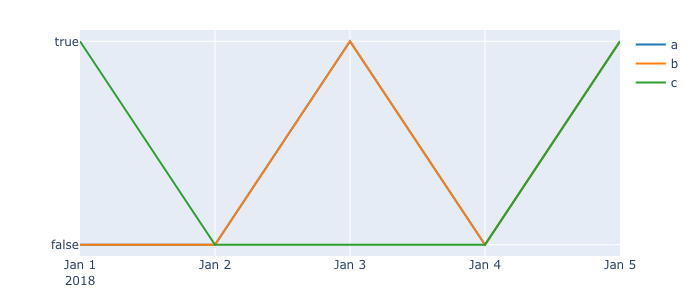

In [11]:
entries.vbt.signals.plot().show_png()

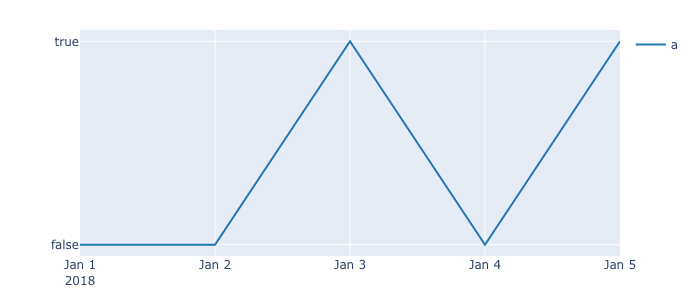

In [12]:
entries['a'].vbt.signals.plot().show_png()

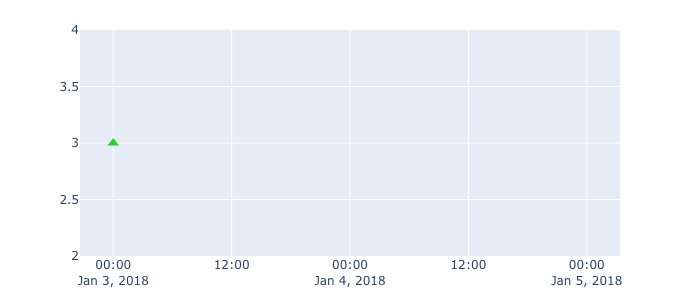

In [13]:
entries['a'].vbt.signals.plot_markers(ts['a'], signal_type='entry').show_png()

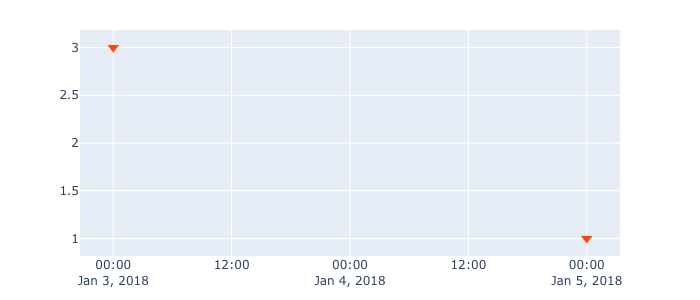

In [14]:
entries['b'].vbt.signals.plot_markers(ts['b'], signal_type='exit').show_png()